<a href="https://colab.research.google.com/github/samuelcampione/UNet-mitochondria-segmentation/blob/main/unet_mitochondria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net for mitochondria segmentation

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
import albumentations as A
import cv2
import itertools
import os
import time
from pathlib import Path
from tqdm.notebook import tqdm
import math
import pickle
from scipy import ndimage

# pytorch stuff
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import jaccard_score as IoU
from sklearn.metrics import jaccard_score


# need for AMP
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

torch.manual_seed(3)
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Using Google Colab with Google Drive
PATH = Path('/content/drive/My Drive/Buck Institute/Zhou Lab/Mitochondria Segmentation')

# paths for datasets
training_images_path = PATH/"training.tif"
training_masks_path = PATH/'training_groundtruth.tif'
testing_images_path = PATH/'testing.tif'
testing_masks_path = PATH/'testing_groundtruth.tif'


In [ ]:
def read_image_slice(tif_path, slice_number):
    tif_image = cv2.imreadmulti(str(tif_path), flags=cv2.IMREAD_GRAYSCALE)[1][slice_number]
    return tif_image

In [ ]:
def read_image_slice_to_binary(tif_path, slice_number):
    _, images = cv2.imreadmulti(str(tif_path), flags=cv2.IMREAD_GRAYSCALE)
    image_slice = images[slice_number]
    _, binary_slice = cv2.threshold(image_slice, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_slice


In [ ]:
# To display image slice
def show_image_slice(img_slice):
    print(np.unique(img_slice))
    plt.imshow(img_slice)
    plt.axis('off')
    plt.show()

In [ ]:
# PyTorch dataset for the mitochondria images
class MitochondriaDataset(Dataset):
    def __init__(self, images_path, masks_path):
        self.images_path = images_path
        self.masks_path = masks_path
        self.num_slices = len(cv2.imreadmulti(str(images_path), flags=cv2.IMREAD_GRAYSCALE)[1])

    def __getitem__(self, index):
        image = read_image_slice(self.images_path, index)
        image = image/255 # 255 for Normalization
        mask = read_image_slice_to_binary(self.masks_path, index)
        image = image[np.newaxis, ...]  # Add a channel dimension
        mask = mask[np.newaxis, ...]    # Add a channel dimension
        return torch.from_numpy(image).float(), torch.from_numpy(mask).float()

    def __len__(self):
        return self.num_slices

In [ ]:
# Simplified U-Net model for binary segmentation
f_size = 7
padding = (int((f_size-1)/2), int((f_size-1)/2))
chs = [32, 64, 128, 256, 512]  # Channel sizes for each layer

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, f_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, f_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [ ]:
class unet(nn.Module):
    def __init__(self):
        super().__init__()
        # pooling
        self.pool = nn.MaxPool2d(2,2)

        # ENCODER
        self.conv00 = ConvBlock(1, chs[0])
        self.conv10 = ConvBlock(chs[0], chs[1])
        self.conv20 = ConvBlock(chs[1], chs[2])
        self.conv30 = ConvBlock(chs[2], chs[3])
        self.conv40 = ConvBlock(chs[3], chs[4])

        # DECODER
        self.upconv31 = nn.ConvTranspose2d(chs[4], chs[3], 2, stride=2)
        self.conv31 = ConvBlock(chs[3]*2, chs[3])
        self.upconv22 = nn.ConvTranspose2d(chs[3], chs[2], 2, stride=2)
        self.conv22 = ConvBlock(chs[2]*2, chs[2])
        self.upconv13 = nn.ConvTranspose2d(chs[2], chs[1], 2, stride=2)
        self.conv13 = ConvBlock(chs[1]*2, chs[1])
        self.upconv04 = nn.ConvTranspose2d(chs[1], chs[0], 2, stride=2)
        self.conv04 = ConvBlock(chs[0]*2, chs[0])

        # final layer
        self.final = nn.Conv2d(chs[0], 1, kernel_size=1)

    def forward(self, x):
        # Encoder Path
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x30 = self.conv30(self.pool(x20))
        x40 = self.conv40(self.pool(x30))

        # Up-sampling and concatenation
        x31 = self.upconv31(x40)
        x31 = self.conv31(torch.cat((x30, x31), dim=1))
        x22 = self.upconv22(x31)
        x22 = self.conv22(torch.cat((x20, x22), dim=1))
        x13 = self.upconv13(x22)
        x13 = self.conv13(torch.cat((x10, x13), dim=1))
        x04 = self.upconv04(x13)
        x04 = self.conv04(torch.cat((x00, x04), dim=1))

        # Final convolution
        x_final = self.final(x04)

        return x_final

In [ ]:
# Instantiate the dataset and downloader for data
dataset = MitochondriaDataset(training_images_path, training_masks_path)
train_dataloader = DataLoader(dataset, batch_size=3, shuffle=True, num_workers=2)

In [ ]:
# Instantiate the model, loss function, and optimizer
model = unet().cuda()

criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for binary segmentation

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
num_epochs = 20

In [ ]:
def train_unet(model, criterion, optimizer, dataloader, num_epochs, val_percent=0.1):
    model.train()
    training_loss = []
    validation_loss = []

    for epoch in range(num_epochs):
        # Determine the number of batches to use for validation
        num_batches = len(dataloader)
        num_val_batches = int(num_batches * val_percent)
        num_train_batches = num_batches - num_val_batches

        # Shuffle the DataLoader indices
        shuffled_indices = torch.randperm(len(dataloader.dataset))
        train_indices = shuffled_indices[:num_train_batches * dataloader.batch_size]
        val_indices = shuffled_indices[num_train_batches * dataloader.batch_size:]

        total_train_loss = 0
        total_val_loss = 0

        # Training phase
        model.train()
        for i, (images, masks) in enumerate(dataloader):
            if i < num_train_batches:
                images, masks = images.cuda(), masks.cuda()
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

        # Validation phase
        model.eval()
        with torch.no_grad():
            for i in val_indices:
                images, masks = dataloader.dataset[i]
                images, masks = images.unsqueeze(0).cuda(), masks.unsqueeze(0).cuda()
                outputs = model(images)
                loss = criterion(outputs, masks)
                total_val_loss += loss.item()

        avg_train_loss = total_train_loss / num_train_batches
        avg_val_loss = total_val_loss / num_val_batches
        training_loss.append(avg_train_loss)
        validation_loss.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    return training_loss, validation_loss


In [ ]:
train_loss, val_loss = train_unet(model, criterion, optimizer, train_dataloader, num_epochs=10, val_percent=0.1)

Epoch 1/10, Training Loss: 0.5163, Validation Loss: 1.7777
Epoch 2/10, Training Loss: 0.3976, Validation Loss: 1.1370
Epoch 3/10, Training Loss: 0.3748, Validation Loss: 1.0901
Epoch 4/10, Training Loss: 0.3567, Validation Loss: 1.0551
Epoch 5/10, Training Loss: 0.3403, Validation Loss: 1.0301
Epoch 6/10, Training Loss: 0.3255, Validation Loss: 0.9626
Epoch 7/10, Training Loss: 0.3092, Validation Loss: 0.9031
Epoch 8/10, Training Loss: 0.2951, Validation Loss: 0.8678
Epoch 9/10, Training Loss: 0.2822, Validation Loss: 0.8431
Epoch 10/10, Training Loss: 0.2697, Validation Loss: 0.8067


In [ ]:
model_save_path = PATH/'mitochondria_unet_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

In [ ]:
def load_model(model_path, model_class=unet):
    """
    Load the saved model from the given path.
    """
    model = model_class().cuda()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

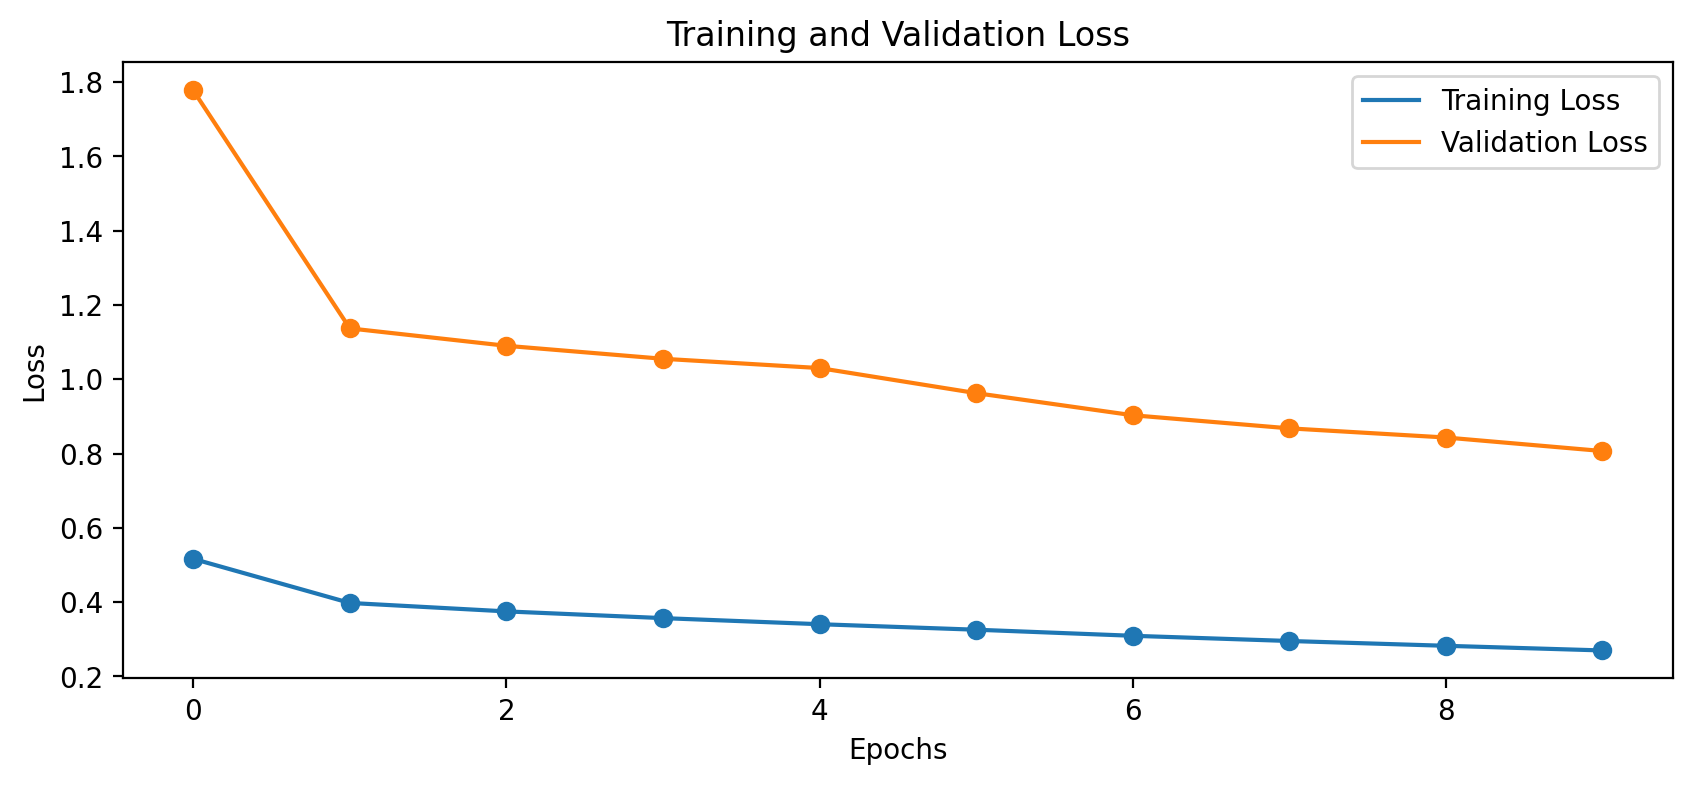

In [ ]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='Training Loss')
plt.scatter(range(10), train_loss)
plt.plot(val_loss, label='Validation Loss')
plt.scatter(range(10), val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
# Calculating accuracy
def accuracy_unet(model, dataloader):
  acc = []
  with torch.no_grad():
      for images, masks in dataloader:
          images, masks = images.cuda(), masks.cuda()
          outputs = model(images)
          preds = outputs > 0  # Using 0 as threshold
          correct = (preds == masks).sum()
          accuracy = correct / (images.size(0) * images.size(2) * images.size(3))
          acc.append(accuracy)
  return acc


In [ ]:
acc_res = accuracy_unet(model, train_dataloader)

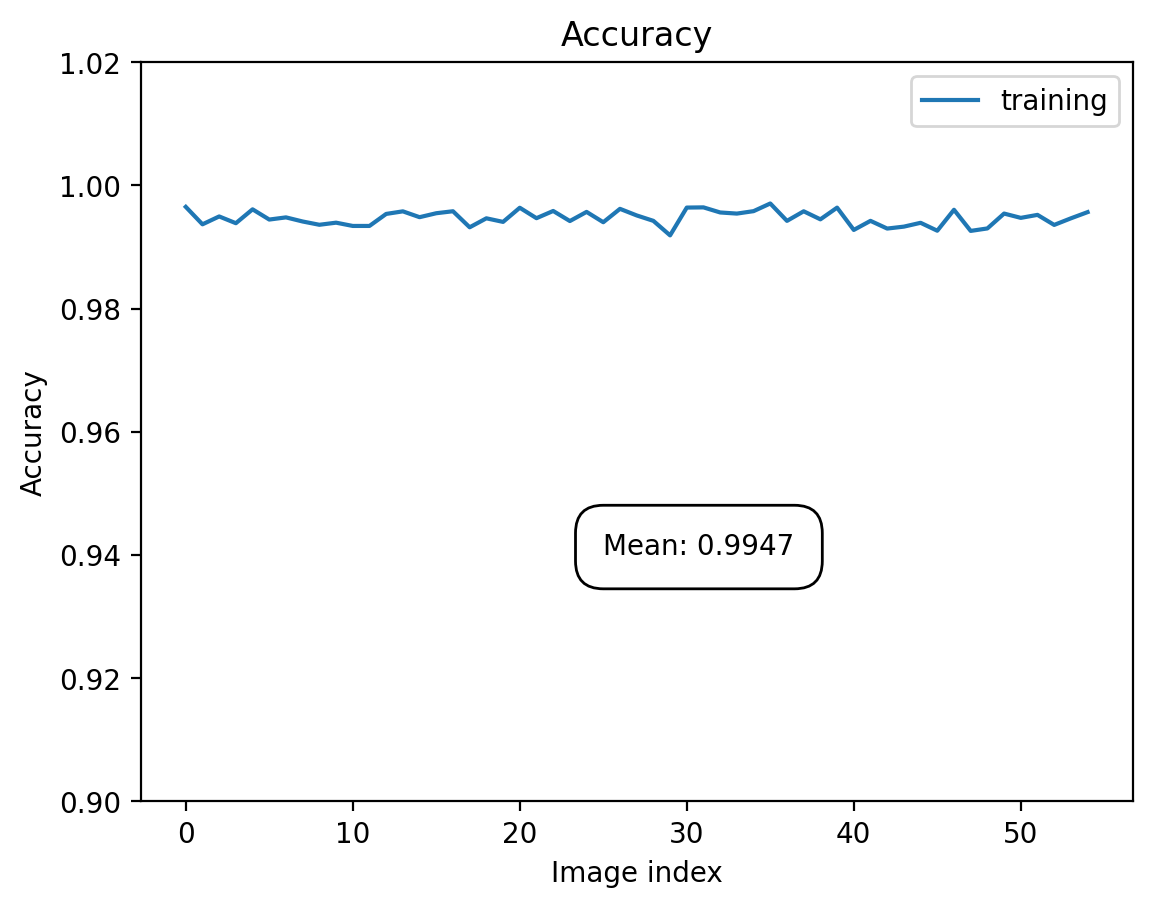

In [ ]:
acc_res_ = [x.tolist() for x in acc_res]
plt.plot(acc_res_, label='training')
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Image index")
plt.ylim(.9, 1.02)
bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1')
plt.text(x=25, y=.94, s=f"Mean: {round(np.mean(acc_res_),4)}", bbox=bbox)
plt.legend()

In [ ]:
def visualize_predictions(model, dataloader, num_images=3):
    model.eval()  # Set the model to evaluation mode
    images, masks = next(iter(dataloader))
    with torch.no_grad():
        images = images.cuda()
        predicted_masks = torch.sigmoid(model(images)) > 0.5  # Apply threshold
        images, predicted_masks = images.cpu().numpy(), predicted_masks.cpu().numpy()

    plt.figure(figsize=(8, 4 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

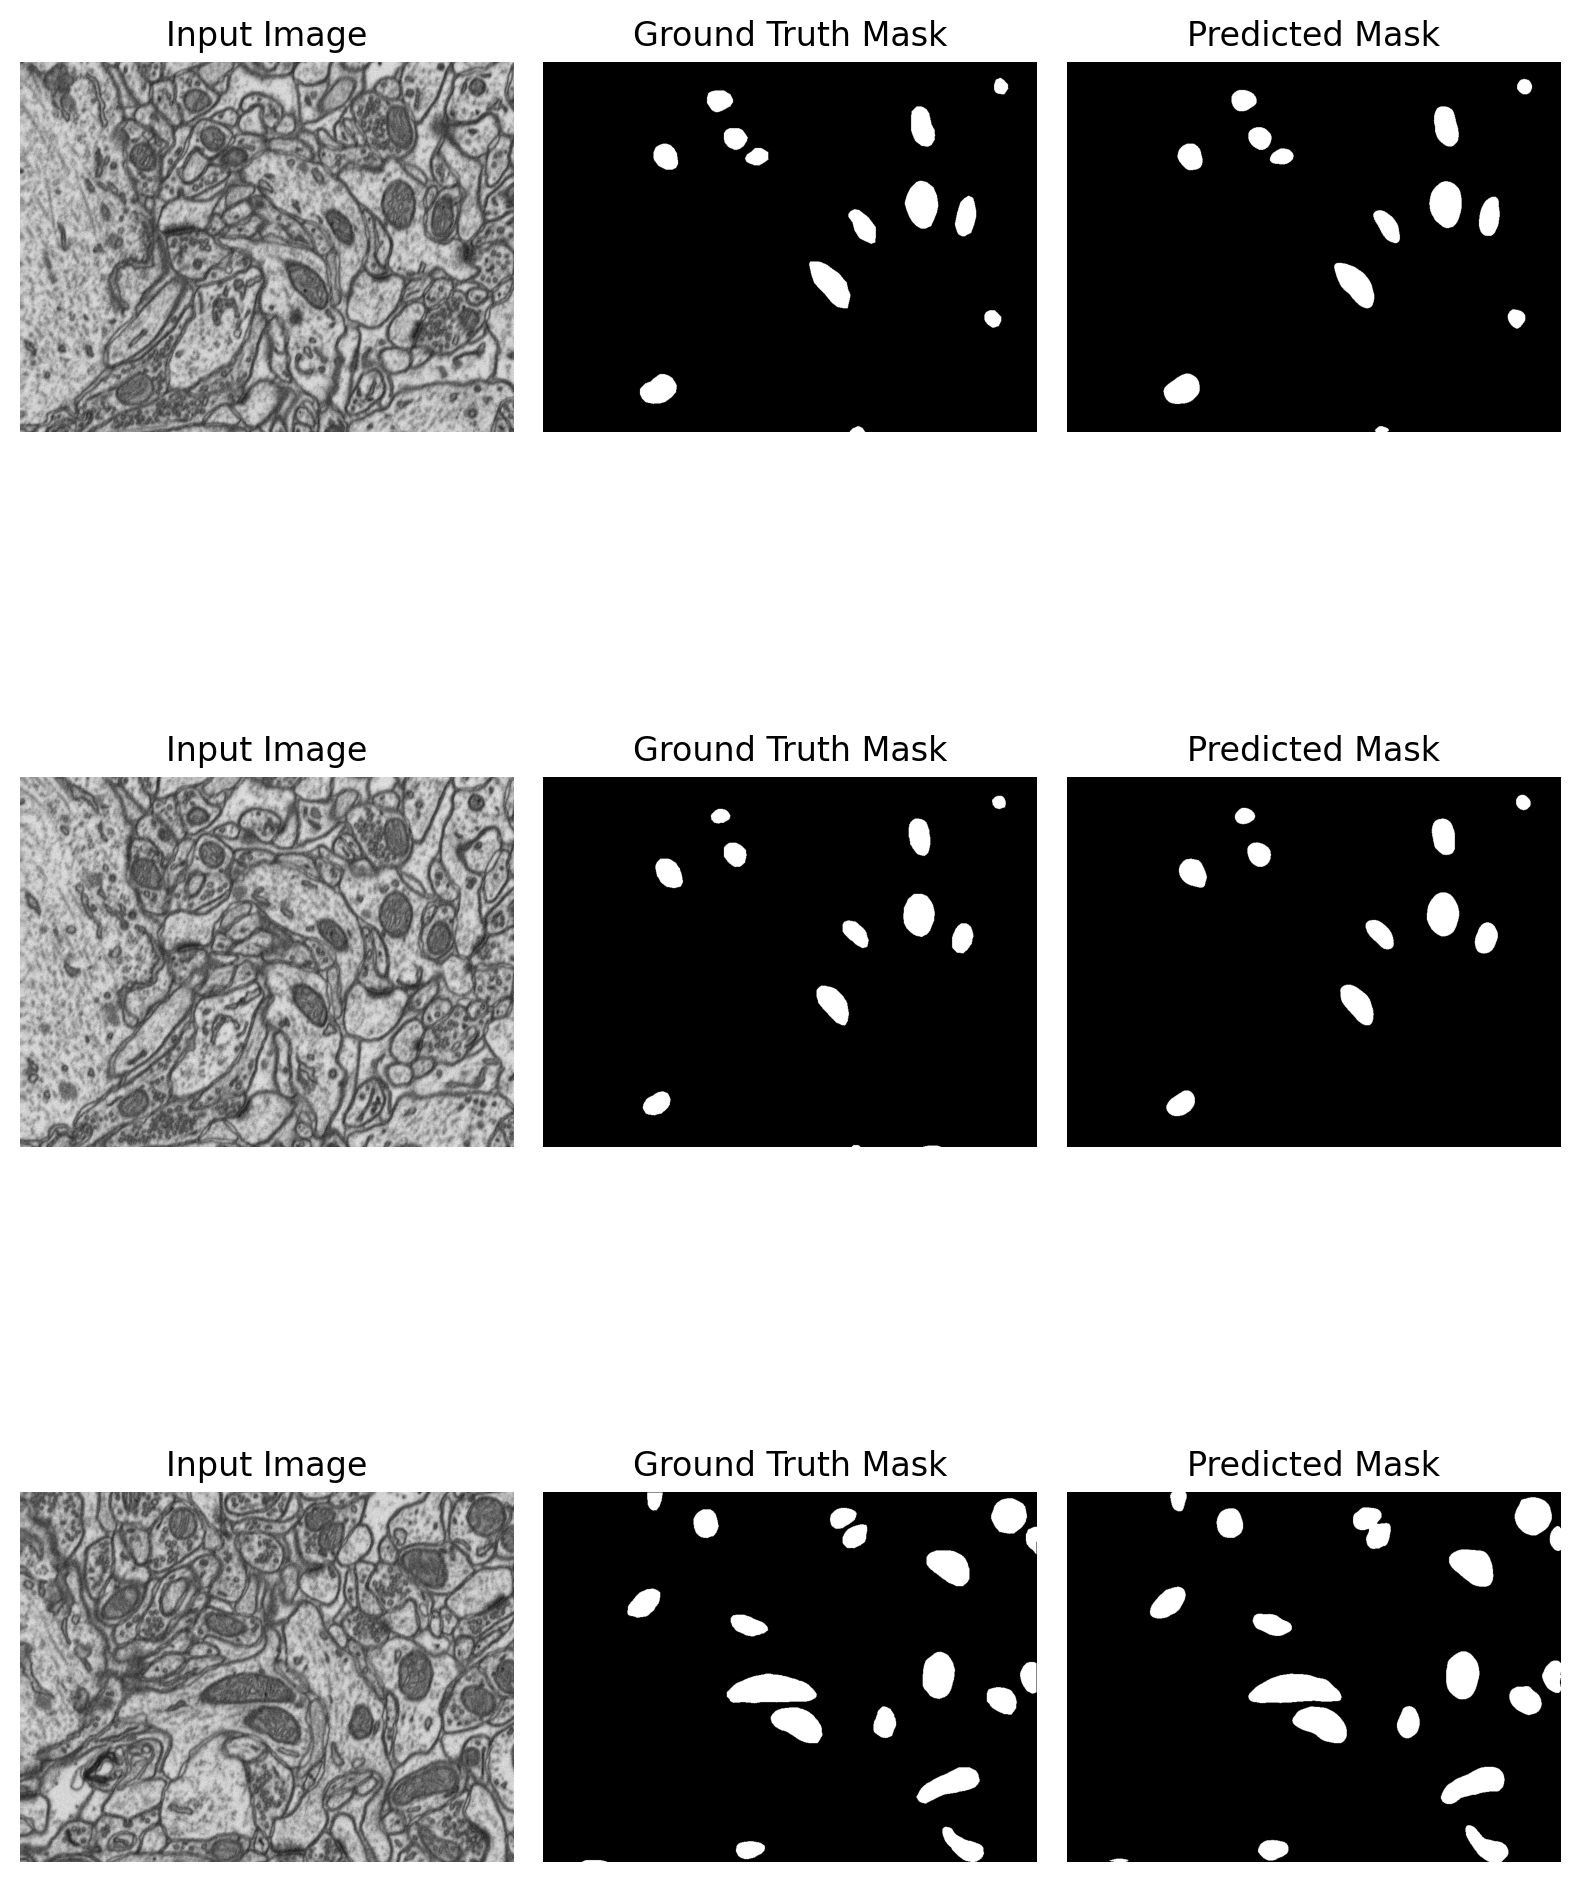

In [ ]:
# Visualize Predictions from the Training Set
visualize_predictions(model, train_dataloader, num_images=3)

## Check Testing Set

In [ ]:
test_dataset = MitochondriaDataset(testing_images_path, testing_masks_path)
test_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=True)

In [ ]:
# Function to apply sigmoid and threshold to convert logits to binary masks
def predict_mask(logits, threshold=0.5):  # was using .5
    probs = torch.sigmoid(logits)
    return probs > threshold

In [ ]:
# Function to plot images and masks
def plot_images(images, masks, predicted_masks, num_images=3):
    plt.figure(figsize=(12, 4 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(masks[i][0], cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predicted_masks[i][0], cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

In [ ]:
def calculate_iou(gt_mask, predicted_mask):
    # Flatten the masks to compare them
    gt_mask_flat = gt_mask.flatten()
    predicted_mask_flat = predicted_mask.flatten()

    # Ensure the masks contain integers
    gt_mask_flat = gt_mask_flat.astype(int)
    predicted_mask_flat = predicted_mask_flat.astype(int)

    return jaccard_score(gt_mask_flat, predicted_mask_flat, average='macro')  # Change 'macro' as needed

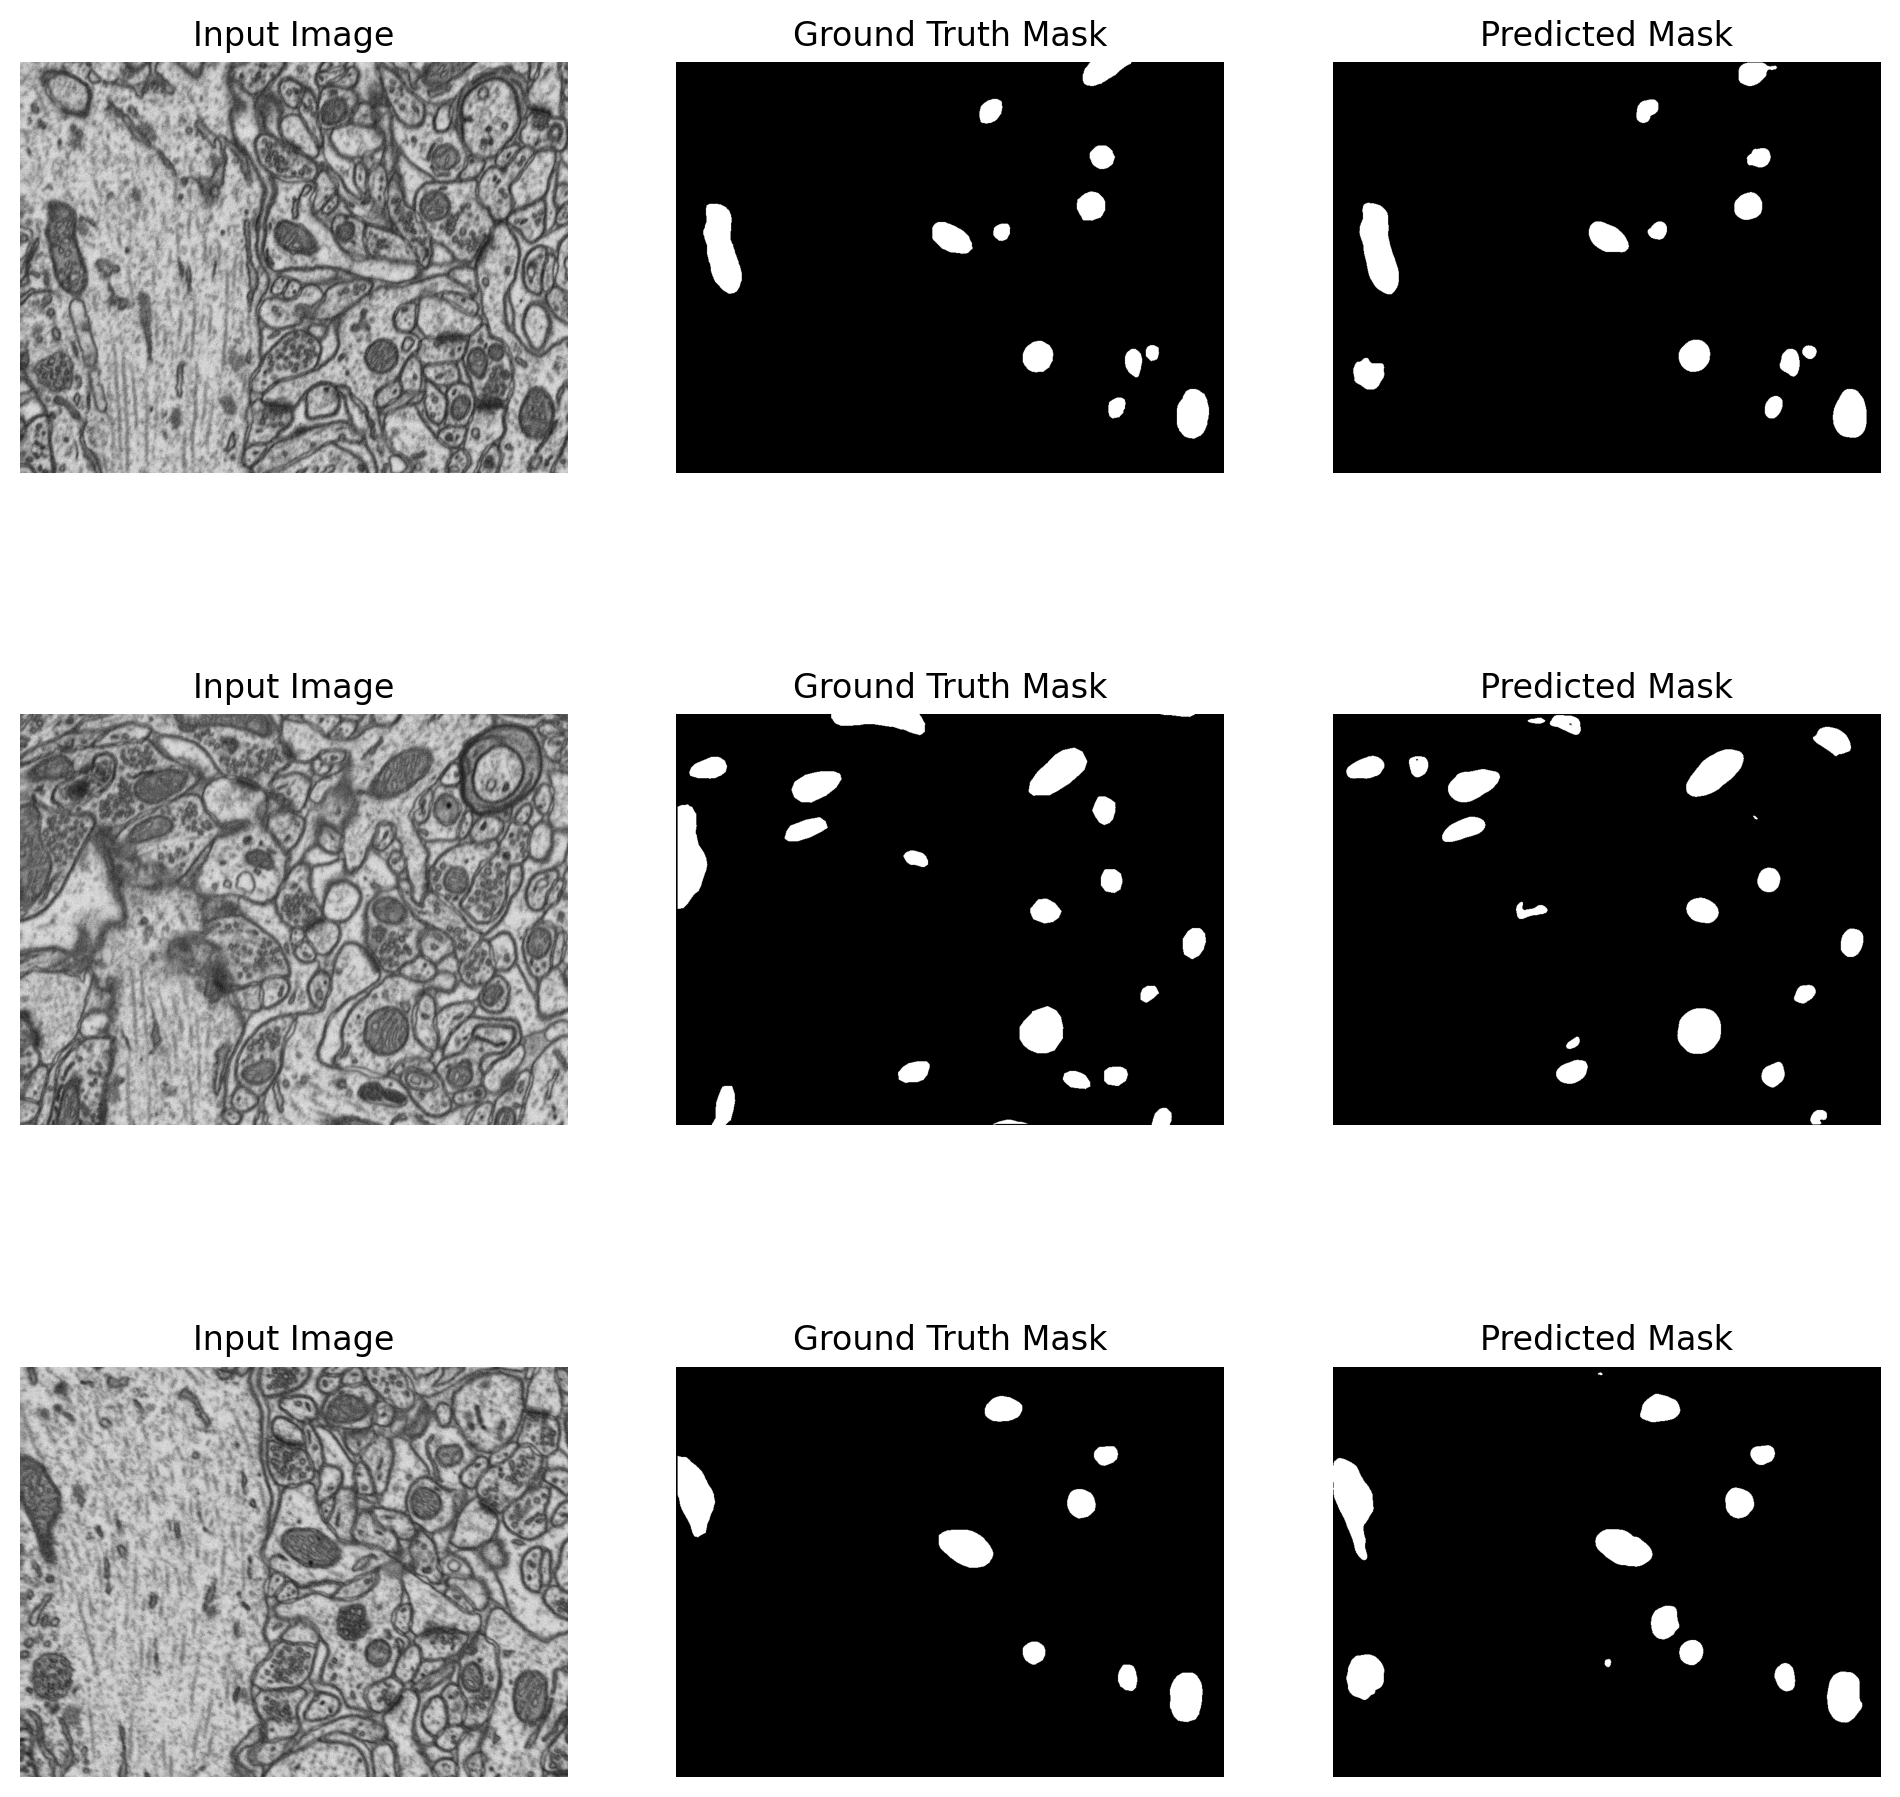

Mean IoU on test set: 0.8535810856269616


In [ ]:
model.eval() # Evaluate the model
with torch.no_grad():

    test_predictions = []

    all_iou = []
    for images, gt_masks in test_dataloader:
      images = images.cuda()
      gt_masks = gt_masks.numpy()
      outputs = model(images)
      predicted_masks = predict_mask(outputs).cpu().numpy()
      test_predictions.extend(predicted_masks)



      # Calculate IoU for each image
      for gt_mask, predicted_mask in zip(gt_masks, predicted_masks):
          iou = calculate_iou(gt_mask, predicted_mask)
          all_iou.append(iou)
    # Visualize some predictions
    plot_images(images.cpu().numpy(), gt_masks, predicted_masks, num_images=min(3, len(images)))

    # Print the mean IoU
    print(f'Mean IoU on test set: {np.mean(all_iou)}')


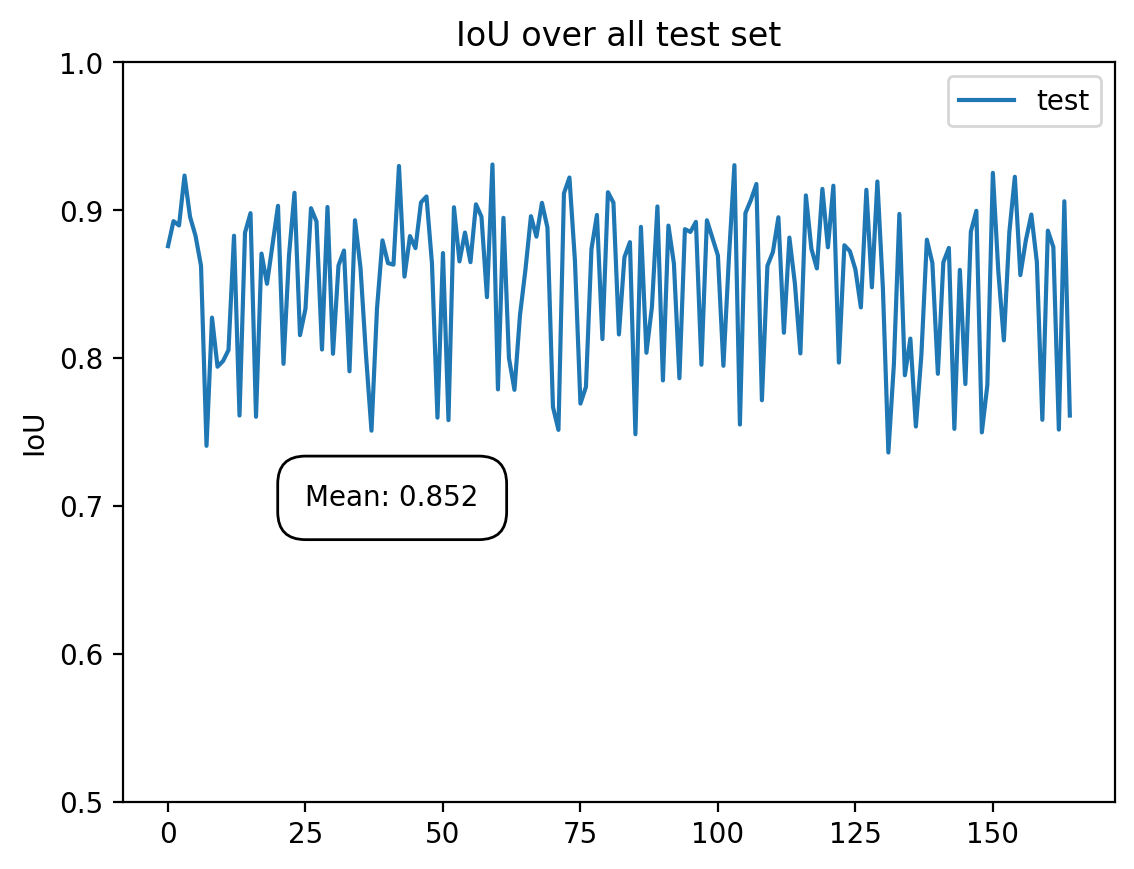

In [ ]:
int_over_union = all_iou.copy()
plt.plot(int_over_union, label='test')
plt.ylabel("IoU")
plt.title("IoU over all test set")
plt.ylim(.5,1)
plt.legend()
bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1')
plt.text(25,.7, f"Mean: {round(np.mean(int_over_union),4)}", bbox=bbox)
plt.show()

In [ ]:
test_acc = accuracy_unet(model, test_dataloader)

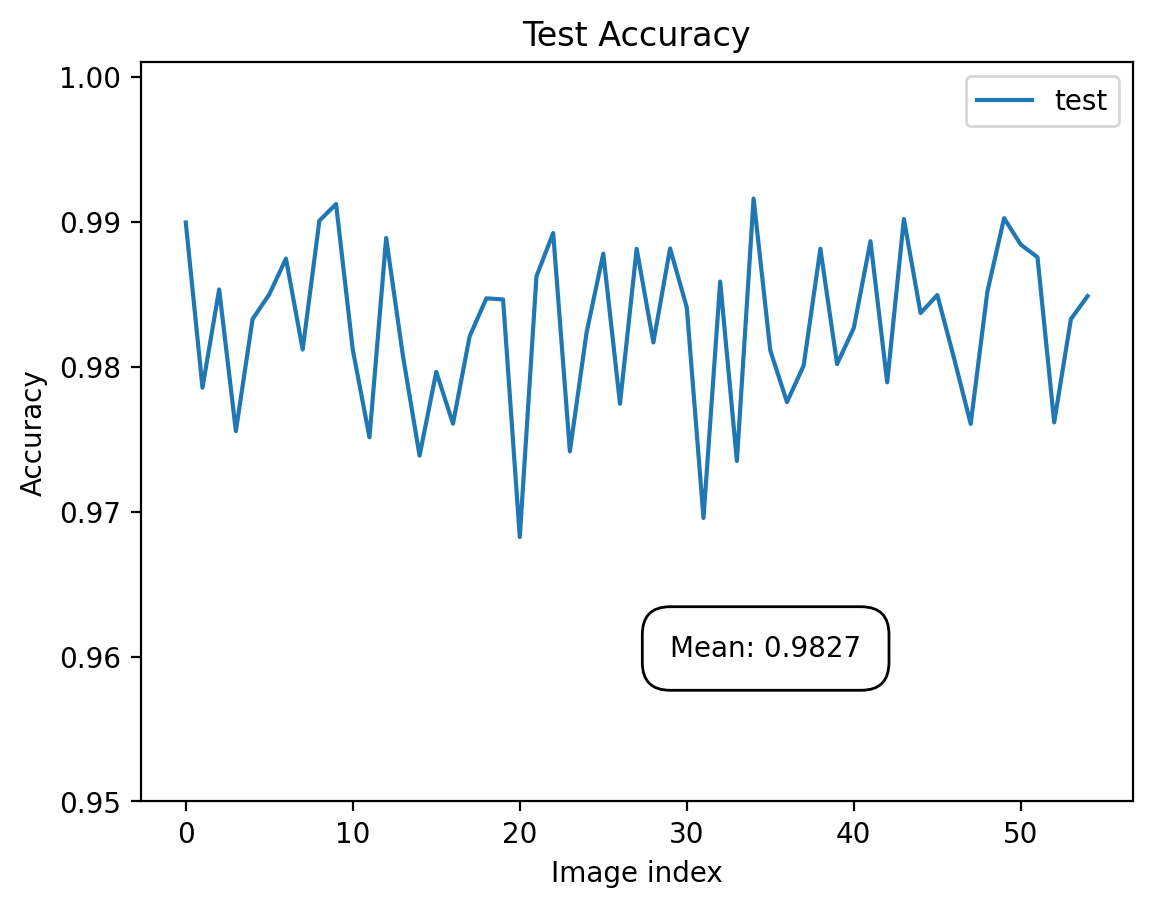

In [ ]:
test_res_ = [x.tolist() for x in test_acc]
plt.plot(test_res_, label='test')
plt.title("Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Image index")
plt.ylim(.95, 1.001)
bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1')
plt.text(x=29, y=.96, s=f"Mean: {round(np.mean(test_res_),4)}", bbox=bbox)
plt.legend()

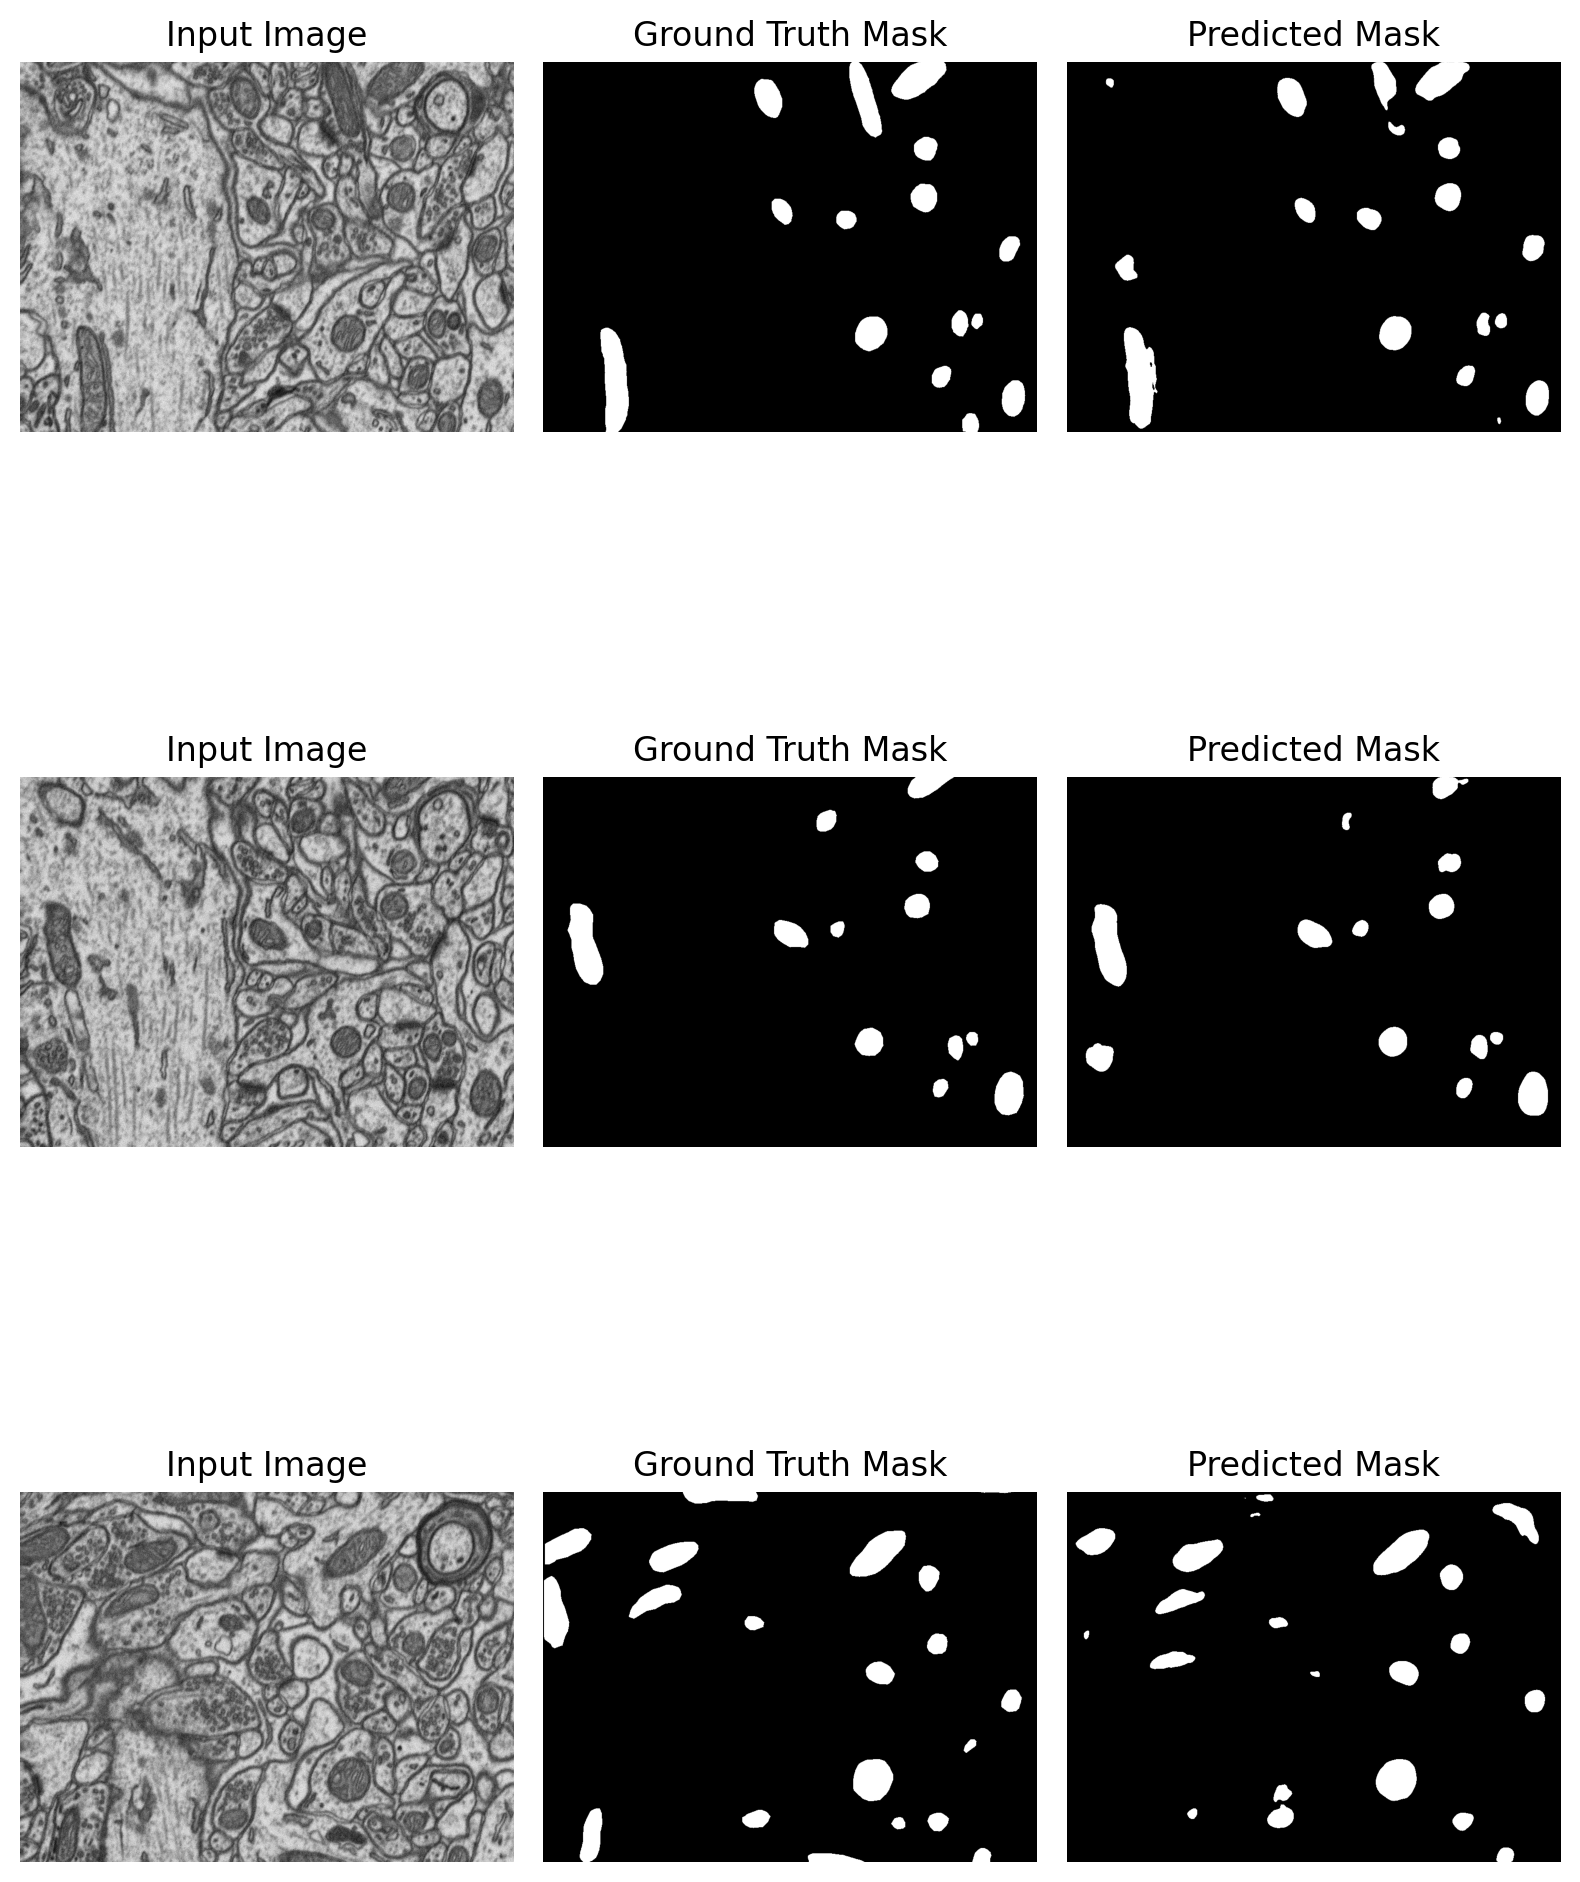

In [ ]:
# Visualize Predictions from the Test Set
visualize_predictions(model, test_dataloader, num_images=3)